# Oversampling 6 Time Bellweathers SVM

### Links:  
Feature Importance: https://towardsdatascience.com/a-practical-guide-to-interpreting-and-visualising-support-vector-machines-97d2a5b0564e   
Visualisation: https://www.machinecurve.com/index.php/2020/05/05/how-to-visualize-support-vectors-of-your-svm-classifier/

### Import Libaries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics

from sklearn.metrics import classification_report

### Import & Clean Dataset

In [4]:
pd.set_option('display.max_columns', None, 'display.max_rows', None)
pd.options.mode.chained_assignment = None

In [5]:
df = pd.read_csv('D:/MEGAN DATA/ASDRP/Fall2020/Bellwether Analysis/data/segmented_data/training_data.csv')
#df = pd.read_csv('D:/MEGAN DATA/ASDRP/Fall2020/Bellwether Analysis/data/segmented_data/data_2004_2020.csv')

In [6]:
df.head()

Unnamed: 0  Unnamed: 0.1   fips       state      county  wins  \
0         575           575  48395       Texas   Robertson     2   
1         478           478  41005      Oregon   Clackamas     5   
2         576           576  48439       Texas     Tarrant     4   
3          40            40   6059  California      Orange     3   
4         591           591  51029    Virginia  Buckingham     5   

   poverty_rate    population  persons_in_poverty  rural_urban_code  \
0     33.150000  1.540050e+04         5119.000000               3.0   
1      8.566667  2.502842e+05        20179.666667               1.0   
2     12.650000  1.073627e+06       132937.500000               1.0   
3      9.116667  2.026096e+06       190122.666667               1.0   
4     30.316667  1.181067e+04         3473.833333               1.0   

   urban_influence_code  metro  civilian_labor_force    employed  unemployed  \
0                   2.0    1.0               7311.20     6889.45      421.75   
1                   1.0    1.0             200240.00   188115.90    12124.10   
2                   1.0    1.0             920432.00   872758.30    47673.70   
3                   1.0    1.0            1571954.95  1491304.95    80650.00   
4                   1.0    1.0               6546.20     6176.50      369.70   

   unemployment_rate  no_diploma  diploma_only  some_college/associate_degree  \
0              5.760      4121.8        2941.8                         1664.4   
1              6.090     26561.8       50396.6                        58013.6   
2              5.205    165316.0      191312.2                       209060.8   
3              5.145    283578.6      322274.4                       423207.8   
4              5.635      3884.4        2968.6                         1306.0   

   completed_college/bachelor_degree  percent_no_diploma  \
0                             1033.0               44.34   
1                            50354.4               17.80   
2                           190790.4               26.20   
3                           442794.0               20.66   
4                              754.0               48.98   

   percent_diploma_only  percent_some_college/associate_degree  \
0                 29.46                                  16.08   
1                 29.32                                  28.54   
2                 26.16                                  25.22   
3                 24.30                                  27.64   
4                 30.34                                  12.78   

   percent_completed_college/bachelor_degree  percent_white_male  \
0                                       9.82           21.908913   
1                                      23.28           21.908913   
2                                      21.14           21.908913   
3                                      26.02           36.469885   
4                                       7.54           21.908913   

   percent_white_female  percent_black_male  percent_black_female  \
0             21.965378           22.170729             26.608751   
1             21.965378           22.170729             26.608751   
2             21.965378           22.170729             26.608751   
3             36.744420            1.062695              0.993823   
4             21.965378           22.170729             26.608751   

   percent_native_american_male  percent_native_american_female  \
0                      0.295598                        0.268220   
1                      0.295598                        0.268220   
2                      0.295598                        0.268220   
3                      0.534732                        0.518284   
4                      0.295598                        0.268220   

   percent_asian_male  percent_asian_female  percent_hispanic_male  \
0            1.702543              2.332841               5.199671   
1            1.702543              2.332841               5.199671   
2   

In [7]:
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['Unnamed: 0.1'], axis=1)
len(df['wins'])

424

In [8]:
# Add 2020 bellwether code (here we specify wins to 6)
# Specifying a bellwether to be either 5 or 6 wins would result in 59 bellweathers under the new classification
#  bellwether --> 1, non-bellwether --> 0

binary_bellweathers = []
for i, v in enumerate(df['wins']):
    if df.iloc[i, 3] == 5 or df.iloc[i, 3] == 6:
        binary_bellweathers.append(1)
    elif df.iloc[i, 3] < 5:
        binary_bellweathers.append(0)

In [9]:
binary_bellweathers.count(1)

82

In [9]:
# gets rid of irrelevant columns, strings, and wins (since that would give the model 100% accuracy)
df = df.drop(['fips', 'wins'], axis=1)
df = df.drop(['state', 'county'], axis=1)
df.head()

poverty_rate    population  persons_in_poverty  rural_urban_code  \
0     33.150000  1.540050e+04         5119.000000               3.0   
1      8.566667  2.502842e+05        20179.666667               1.0   
2     12.650000  1.073627e+06       132937.500000               1.0   
3      9.116667  2.026096e+06       190122.666667               1.0   
4     30.316667  1.181067e+04         3473.833333               1.0   

   urban_influence_code  metro  civilian_labor_force    employed  unemployed  \
0                   2.0    1.0               7311.20     6889.45      421.75   
1                   1.0    1.0             200240.00   188115.90    12124.10   
2                   1.0    1.0             920432.00   872758.30    47673.70   
3                   1.0    1.0            1571954.95  1491304.95    80650.00   
4                   1.0    1.0               6546.20     6176.50      369.70   

   unemployment_rate  no_diploma  diploma_only  some_college/associate_degree  \
0              5.760      4121.8        2941.8                         1664.4   
1              6.090     26561.8       50396.6                        58013.6   
2              5.205    165316.0      191312.2                       209060.8   
3              5.145    283578.6      322274.4                       423207.8   
4              5.635      3884.4        2968.6                         1306.0   

   completed_college/bachelor_degree  percent_no_diploma  \
0                             1033.0               44.34   
1                            50354.4               17.80   
2                           190790.4               26.20   
3                           442794.0               20.66   
4                              754.0               48.98   

   percent_diploma_only  percent_some_college/associate_degree  \
0                 29.46                                  16.08   
1                 29.32                                  28.54   
2                 26.16                                  25.22   
3                 24.30                                  27.64   
4                 30.34                                  12.78   

   percent_completed_college/bachelor_degree  percent_white_male  \
0                                       9.82           21.908913   
1                                      23.28           21.908913   
2                                      21.14           21.908913   
3                                      26.02           36.469885   
4                                       7.54           21.908913   

   percent_white_female  percent_black_male  percent_black_female  \
0             21.965378           22.170729             26.608751   
1             21.965378           22.170729             26.608751   
2             21.965378           22.170729             26.608751   
3             36.744420            1.062695              0.993823   
4             21.965378           22.170729             26.608751   

   percent_native_american_male  percent_native_american_female  \
0                      0.295598                        0.268220   
1                      0.295598                        0.268220   
2                      0.295598                        0.268220   
3                      0.534732                        0.518284   
4                      0.295598                        0.268220   

   percent_asian_male  percent_asian_female  percent_hispanic_male  \
0            1.702543              2.332841               5.199671   
1            1.702543              2.332841               5.199671   
2            1.702543              2.332841               5.199671   
3            9.478358             10.501137              17.005110   
4            1.702543              2.332841               5.199671   

   percent_hispanic_female  cumulative_confirmed_cases  cumulative_deaths  
0                 4.980366                      166359               2679  
1                 4.980366                     146

In [10]:
df.insert(0, "bellweather?", binary_bellweathers)

In [11]:
df.head()

bellweather?  poverty_rate    population  persons_in_poverty  \
0             0     33.150000  1.540050e+04         5119.000000   
1             1      8.566667  2.502842e+05        20179.666667   
2             0     12.650000  1.073627e+06       132937.500000   
3             0      9.116667  2.026096e+06       190122.666667   
4             1     30.316667  1.181067e+04         3473.833333   

   rural_urban_code  urban_influence_code  metro  civilian_labor_force  \
0               3.0                   2.0    1.0               7311.20   
1               1.0                   1.0    1.0             200240.00   
2               1.0                   1.0    1.0             920432.00   
3               1.0                   1.0    1.0            1571954.95   
4               1.0                   1.0    1.0               6546.20   

     employed  unemployed  unemployment_rate  no_diploma  diploma_only  \
0     6889.45      421.75              5.760      4121.8        2941.8   
1   188115.90    12124.10              6.090     26561.8       50396.6   
2   872758.30    47673.70              5.205    165316.0      191312.2   
3  1491304.95    80650.00              5.145    283578.6      322274.4   
4     6176.50      369.70              5.635      3884.4        2968.6   

   some_college/associate_degree  completed_college/bachelor_degree  \
0                         1664.4                             1033.0   
1                        58013.6                            50354.4   
2                       209060.8                           190790.4   
3                       423207.8                           442794.0   
4                         1306.0                              754.0   

   percent_no_diploma  percent_diploma_only  \
0               44.34                 29.46   
1               17.80                 29.32   
2               26.20                 26.16   
3               20.66                 24.30   
4               48.98                 30.34   

   percent_some_college/associate_degree  \
0                                  16.08   
1                                  28.54   
2                                  25.22   
3                                  27.64   
4                                  12.78   

   percent_completed_college/bachelor_degree  percent_white_male  \
0                                       9.82           21.908913   
1                                      23.28           21.908913   
2                                      21.14           21.908913   
3                                      26.02           36.469885   
4                                       7.54           21.908913   

   percent_white_female  percent_black_male  percent_black_female  \
0             21.965378           22.170729             26.608751   
1             21.965378           22.170729             26.608751   
2             21.965378           22.170729             26.608751   
3             36.744420            1.062695              0.993823   
4             21.965378           22.170729             26.608751   

   percent_native_american_male  percent_native_american_female  \
0                      0.295598                        0.268220   
1                      0.295598                        0.268220   
2                      0.295598                        0.268220   
3                      0.534732                        0.518284   
4                      0.295598                        0.268220   

   percent_asian_male  percent_asian_female  percent_hispanic_male  \
0            1.702543              2.332841               5.199671   
1            1.702543              2.332841               5.199671   
2            1.702543              2.332841               5.199671   
3            9.478358             10.501137              17.005110   
4            1.702543              2.332841               5.199671   

   percent_hispanic_female  cumulative_confirmed_cases  cumulative_deaths  
0          

In [12]:
df["bellweather?"].value_counts()

0    342
1     82
Name: bellweather?, dtype: int64

In [13]:
# only take the 59 bellweathers

df1 = df[df["bellweather?"] == 1]

In [14]:
df1.head()

bellweather?  poverty_rate    population  persons_in_poverty  \
1              1      8.566667  2.502842e+05        20179.666667   
4              1     30.316667  1.181067e+04         3473.833333   
6              1     20.800000  8.625833e+03         1655.500000   
10             1     12.583333  1.317832e+05        13073.333333   
17             1     12.433333  2.015758e+06       250528.333333   

    rural_urban_code  urban_influence_code  metro  civilian_labor_force  \
1                1.0                   1.0    1.0             200240.00   
4                1.0                   1.0    1.0               6546.20   
6                1.0                   1.0    1.0               5517.35   
10               8.0                   4.0    0.0             113216.10   
17               1.0                   1.0    1.0            1514329.75   

     employed  unemployed  unemployment_rate  no_diploma  diploma_only  \
1    188115.9    12124.10              6.090     26561.8       50396.6   
4      6176.5      369.70              5.635      3884.4        2968.6   
6      5222.6      294.75              5.300      2125.6        1887.2   
10   108267.4     4948.70              4.355     21216.2       27341.2   
17  1426063.8    88265.95              5.815    270357.2      342407.4   

    some_college/associate_degree  completed_college/bachelor_degree  \
1                         58013.6                            50354.4   
4                          1306.0                              754.0   
6                          1132.8                              879.4   
10                        27341.2                            21638.6   
17                       433566.2                           417128.4   

    percent_no_diploma  percent_diploma_only  \
1                17.80                 29.32   
4                48.98                 30.34   
6                38.92                 30.14   
10               29.50                 28.54   
17               21.02                 25.80   

    percent_some_college/associate_degree  \
1                                   28.54   
4                                   12.78   
6                                   17.18   
10                                  23.78   
17                                  27.64   

    percent_completed_college/bachelor_degree  percent_white_male  \
1                                       23.28           21.908913   
4                                        7.54           21.908913   
6                                       12.62           21.908913   
10                                      16.94           21.908913   
17                                      24.18           38.569749   

    percent_white_female  percent_black_male  percent_black_female  \
1              21.965378           22.170729             26.608751   
4              21.965378           22.170729             26.608751   
6              21.965378           22.170729             26.608751   
10             21.965378           22.170729             26.608751   
17             37.736949            2.959679              2.592406   

    percent_native_american_male  percent_native_american_female  \
1                       0.295598                        0.268220   
4                       0.295598                        0.268220   
6                       0.295598                        0.268220   
10                      0.295598                        0.268220   
17                      0.682090                        0.646117   

    percent_asian_male  percent_asian_female  percent_hispanic_male  \
1             1.702543              2.332841               5.199671   
4             1.702543              2.332841               5.199671   
6             1.702543              2.332841               5.199671   
10            1.702543              2.332841               5.199671   
17            5.602873              6.335811              16.415067   

    percent_hispanic_female  cumul

In [15]:
# increasing the number of bellweathers up to 1287, to give the dataset a roughly 30 - 70 split

df1_repeated = pd.concat([df1]*22, ignore_index=True)

In [16]:
df1_repeated.head()

bellweather?  poverty_rate    population  persons_in_poverty  \
0             1      8.566667  2.502842e+05        20179.666667   
1             1     30.316667  1.181067e+04         3473.833333   
2             1     20.800000  8.625833e+03         1655.500000   
3             1     12.583333  1.317832e+05        13073.333333   
4             1     12.433333  2.015758e+06       250528.333333   

   rural_urban_code  urban_influence_code  metro  civilian_labor_force  \
0               1.0                   1.0    1.0             200240.00   
1               1.0                   1.0    1.0               6546.20   
2               1.0                   1.0    1.0               5517.35   
3               8.0                   4.0    0.0             113216.10   
4               1.0                   1.0    1.0            1514329.75   

    employed  unemployed  unemployment_rate  no_diploma  diploma_only  \
0   188115.9    12124.10              6.090     26561.8       50396.6   
1     6176.5      369.70              5.635      3884.4        2968.6   
2     5222.6      294.75              5.300      2125.6        1887.2   
3   108267.4     4948.70              4.355     21216.2       27341.2   
4  1426063.8    88265.95              5.815    270357.2      342407.4   

   some_college/associate_degree  completed_college/bachelor_degree  \
0                        58013.6                            50354.4   
1                         1306.0                              754.0   
2                         1132.8                              879.4   
3                        27341.2                            21638.6   
4                       433566.2                           417128.4   

   percent_no_diploma  percent_diploma_only  \
0               17.80                 29.32   
1               48.98                 30.34   
2               38.92                 30.14   
3               29.50                 28.54   
4               21.02                 25.80   

   percent_some_college/associate_degree  \
0                                  28.54   
1                                  12.78   
2                                  17.18   
3                                  23.78   
4                                  27.64   

   percent_completed_college/bachelor_degree  percent_white_male  \
0                                      23.28           21.908913   
1                                       7.54           21.908913   
2                                      12.62           21.908913   
3                                      16.94           21.908913   
4                                      24.18           38.569749   

   percent_white_female  percent_black_male  percent_black_female  \
0             21.965378           22.170729             26.608751   
1             21.965378           22.170729             26.608751   
2             21.965378           22.170729             26.608751   
3             21.965378           22.170729             26.608751   
4             37.736949            2.959679              2.592406   

   percent_native_american_male  percent_native_american_female  \
0                      0.295598                        0.268220   
1                      0.295598                        0.268220   
2                      0.295598                        0.268220   
3                      0.295598                        0.268220   
4                      0.682090                        0.646117   

   percent_asian_male  percent_asian_female  percent_hispanic_male  \
0            1.702543              2.332841               5.199671   
1            1.702543              2.332841               5.199671   
2            1.702543              2.332841               5.199671   
3            1.702543              2.332841               5.199671   
4            5.602873              6.335811              16.415067   

   percent_hispanic_female  cumulative_confirmed_cases  cumulative_deaths  
0                

In [17]:
# take all of the non-bellweathers and store them in df2

df2 = df[df["bellweather?"] == 0]

In [18]:
df2["bellweather?"].value_counts()

0    342
Name: bellweather?, dtype: int64

In [19]:
df_new = df1_repeated.append(df2)

In [20]:
df_new["bellweather?"].value_counts()

1    1804
0     342
Name: bellweather?, dtype: int64

In [21]:
len(df_new)

2146

In [22]:
# store all features except wins in x_new
# store wins in y_new

x_new = df_new.loc[:, df_new.columns != 'bellweather?']
y_new = df_new["bellweather?"]

In [23]:
x_new.head()

poverty_rate    population  persons_in_poverty  rural_urban_code  \
0      8.566667  2.502842e+05        20179.666667               1.0   
1     30.316667  1.181067e+04         3473.833333               1.0   
2     20.800000  8.625833e+03         1655.500000               1.0   
3     12.583333  1.317832e+05        13073.333333               8.0   
4     12.433333  2.015758e+06       250528.333333               1.0   

   urban_influence_code  metro  civilian_labor_force   employed  unemployed  \
0                   1.0    1.0             200240.00   188115.9    12124.10   
1                   1.0    1.0               6546.20     6176.5      369.70   
2                   1.0    1.0               5517.35     5222.6      294.75   
3                   4.0    0.0             113216.10   108267.4     4948.70   
4                   1.0    1.0            1514329.75  1426063.8    88265.95   

   unemployment_rate  no_diploma  diploma_only  some_college/associate_degree  \
0              6.090     26561.8       50396.6                        58013.6   
1              5.635      3884.4        2968.6                         1306.0   
2              5.300      2125.6        1887.2                         1132.8   
3              4.355     21216.2       27341.2                        27341.2   
4              5.815    270357.2      342407.4                       433566.2   

   completed_college/bachelor_degree  percent_no_diploma  \
0                            50354.4               17.80   
1                              754.0               48.98   
2                              879.4               38.92   
3                            21638.6               29.50   
4                           417128.4               21.02   

   percent_diploma_only  percent_some_college/associate_degree  \
0                 29.32                                  28.54   
1                 30.34                                  12.78   
2                 30.14                                  17.18   
3                 28.54                                  23.78   
4                 25.80                                  27.64   

   percent_completed_college/bachelor_degree  percent_white_male  \
0                                      23.28           21.908913   
1                                       7.54           21.908913   
2                                      12.62           21.908913   
3                                      16.94           21.908913   
4                                      24.18           38.569749   

   percent_white_female  percent_black_male  percent_black_female  \
0             21.965378           22.170729             26.608751   
1             21.965378           22.170729             26.608751   
2             21.965378           22.170729             26.608751   
3             21.965378           22.170729             26.608751   
4             37.736949            2.959679              2.592406   

   percent_native_american_male  percent_native_american_female  \
0                      0.295598                        0.268220   
1                      0.295598                        0.268220   
2                      0.295598                        0.268220   
3                      0.295598                        0.268220   
4                      0.682090                        0.646117   

   percent_asian_male  percent_asian_female  percent_hispanic_male  \
0            1.702543              2.332841               5.199671   
1            1.702543              2.332841               5.199671   
2            1.702543              2.332841               5.199671   
3            1.702543              2.332841               5.199671   
4            5.602873              6.335811              16.415067   

   percent_hispanic_female  cumulative_confirmed_cases  cumulative_deaths  
0                 4.980366                     1467658              22108  
1                 4.980366                      284371  

In [24]:
# approx 30% bellwethers and 70% non bellwethers
y_new.value_counts()

1    1804
0     342
Name: bellweather?, dtype: int64

In [25]:
x_train_new = x_new
y_train_new = y_new

In [26]:
pd.set_option('display.max_columns', None, 'display.max_rows', None)
pd.options.mode.chained_assignment = None

df = pd.read_csv('D:/MEGAN DATA/ASDRP/Fall2020/Bellwether Analysis/data/segmented_data/test_data.csv')

df.head()

df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['Unnamed: 0.1'], axis=1)
len(df['wins'])

# Add 2020 bellwether code (here we specify wins to 6)
# Specifying a bellwether to be either 5 or 6 wins would result in 59 bellweathers under the new classification
#  bellwether --> 1, non-bellwether --> 0

binary_bellweathers = []
for i, v in enumerate(df['wins']):
    if df.iloc[i, 3] == 5 or df.iloc[i, 3] == 6:
        binary_bellweathers.append(1)
    elif df.iloc[i, 3] < 5:
        binary_bellweathers.append(0)

binary_bellweathers.count(1)

# gets rid of irrelevant columns, strings, and wins (since that would give the model 100% accuracy)
df = df.drop(['fips', 'wins'], axis=1)
df = df.drop(['state', 'county'], axis=1)
df.head()

df.insert(0, "bellweather?", binary_bellweathers)

df.head()

df["bellweather?"].value_counts()

# only take the 59 bellweathers

df1 = df[df["bellweather?"] == 1]

df1.head()

# increasing the number of bellweathers up to 1287, to give the dataset a roughly 30 - 70 split

df1_repeated = pd.concat([df1]*22, ignore_index=True)

df1_repeated.head()

# take all of the non-bellweathers and store them in df2

df2 = df[df["bellweather?"] == 0]

df2["bellweather?"].value_counts()

df_new = df1_repeated.append(df2)

df_new["bellweather?"].value_counts()

len(df_new)

# store all features except wins in x_new
# store wins in y_new

x_new = df_new.loc[:, df_new.columns != 'bellweather?']
y_new = df_new["bellweather?"]

x_new.head()

# approx 30% bellwethers and 70% non bellwethers
y_new.value_counts()

x_test_new = x_new
y_test_new = y_new

In [27]:
pd.set_option('display.max_columns', None, 'display.max_rows', None)
pd.options.mode.chained_assignment = None

df = pd.read_csv('D:/MEGAN DATA/ASDRP/Fall2020/Bellwether Analysis/data/segmented_data/validation_data.csv')

df.head()

df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['Unnamed: 0.1'], axis=1)
len(df['wins'])

# Add 2020 bellwether code (here we specify wins to 6)
# Specifying a bellwether to be either 5 or 6 wins would result in 59 bellweathers under the new classification
#  bellwether --> 1, non-bellwether --> 0

binary_bellweathers = []
for i, v in enumerate(df['wins']):
    if df.iloc[i, 3] == 5 or df.iloc[i, 3] == 6:
        binary_bellweathers.append(1)
    elif df.iloc[i, 3] < 5:
        binary_bellweathers.append(0)

binary_bellweathers.count(1)

# gets rid of irrelevant columns, strings, and wins (since that would give the model 100% accuracy)
df = df.drop(['fips', 'wins'], axis=1)
df = df.drop(['state', 'county'], axis=1)
df.head()

df.insert(0, "bellweather?", binary_bellweathers)

df.head()

df["bellweather?"].value_counts()

# only take the 59 bellweathers

df1 = df[df["bellweather?"] == 1]

df1.head()

# increasing the number of bellweathers up to 1287, to give the dataset a roughly 30 - 70 split

df1_repeated = pd.concat([df1]*22, ignore_index=True)

df1_repeated.head()

# take all of the non-bellweathers and store them in df2

df2 = df[df["bellweather?"] == 0]

df2["bellweather?"].value_counts()

df_new = df1_repeated.append(df2)

df_new["bellweather?"].value_counts()

len(df_new)

# store all features except wins in x_new
# store wins in y_new

x_new = df_new.loc[:, df_new.columns != 'bellweather?']
y_new = df_new["bellweather?"]

x_new.head()

# approx 30% bellwethers and 70% non bellwethers
y_new.value_counts()

x_validation = x_new
y_validation = y_new

### Define Functions

In [28]:
def run_multiple_times(num_runs, c_value):
    x_train_average = {}
    x_test_average = {}
    y_train_average = {}
    y_test_average = {}
    classifier_average = {}
    y_pred_average = {}
    accuracy_list=[]
    sum = 0

    for x in range(num_runs):
        # split each sample into 75% training and 25% testing
        x_train_average[x], x_test_average[x], y_train_average[x], y_test_average[x] = \
            train_test_split(x_new, y_new, test_size=0.25)

        classifier_average[x] = SVC(kernel='rbf', C=c_value)

        classifier_average[x].fit(x_train_average[x], y_train_average[x])

        x_temp = x_new

        y_pred_average[x] = classifier_average[x].predict(x_test_average[x])
        (y_test_average[x] - y_pred_average[x]).map(lambda x_temp: x_temp*x_temp).sum()
        y = metrics.accuracy_score(y_test_average[x], y_pred_average[x])
        accuracy_list.append(y)

    # print average accuracy and standard deviation
    print("Average Accuracy: {0}".format(statistics.mean(accuracy_list)))
    print("Standard Deviation: {0}".format(statistics.stdev(accuracy_list)))

In [29]:
def svm_accuracy(clf):
    y_pred_class = clf.predict(x_train_new)
    training_accuracy = metrics.accuracy_score(y_train_new, y_pred_class)
    training_error = 1 - training_accuracy
    print("SVM Training set accuracy: {0}, Training set error: {1}".format(training_accuracy, training_error))
    y_pred_class = clf.predict(x_test_new)
    testing_accuracy = metrics.accuracy_score(y_test_new, y_pred_class)
    testing_error = 1 - testing_accuracy
    print("SVM Test accuracy: {0}, Test error: {1} \n".format(testing_accuracy, testing_error))

In [30]:
def svm_report(clf):
    print("CLassification Report")
    y_pred_new = clf.predict(x_test_new)
    print(classification_report(y_test_new, y_pred_new))

### Using SVC 
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [31]:
# fit model (default parameters)
svclassifier = SVC(kernel='rbf')
svclassifier.fit(x_train_new, y_train_new)

SVC()

In [32]:
svm_accuracy(svclassifier)

SVM Training set accuracy: 0.8415657036346692, Training set error: 0.1584342963653308
SVM Test accuracy: 0.8013245033112583, Test error: 0.19867549668874174 



In [33]:
svm_report(svclassifier)

CLassification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.80      1.00      0.89       484

    accuracy                           0.80       604
   macro avg       0.40      0.50      0.44       604
weighted avg       0.64      0.80      0.71       604



d:\users\user1\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


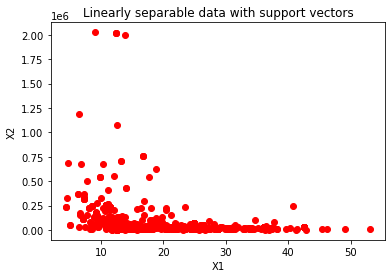

In [34]:
# https://www.machinecurve.com/index.php/2020/05/05/how-to-visualize-support-vectors-of-your-svm-classifier/

support_vectors = svclassifier.support_vectors_
support_vectors

# Visualize support vectors
# plt.scatter(x_train_new[:,0], x_train_new[:,1])
plt.scatter(support_vectors[:,0], support_vectors[:,1], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### Run SVC Classifier 30 times

In [35]:
run_multiple_times(30, 1) #default c value

Average Accuracy: 0.8767407407407407
Standard Deviation: 0.015699751303866687


### C value tuning

In [36]:
cs = [0.1, 1, 10, 100, 1000, 10000]
for c in cs:
    svclassifier = SVC(kernel='rbf', C=c)
    svclassifier.fit(x_train_new, y_train_new)
    print("C value of " + str(c))
    svm_accuracy(svclassifier)
    svm_report(svclassifier)

C value of 0.1
SVM Training set accuracy: 0.8406337371854613, Training set error: 0.1593662628145387
SVM Test accuracy: 0.8013245033112583, Test error: 0.19867549668874174 

CLassification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.80      1.00      0.89       484

    accuracy                           0.80       604
   macro avg       0.40      0.50      0.44       604
weighted avg       0.64      0.80      0.71       604



d:\users\user1\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C value of 1
SVM Training set accuracy: 0.8415657036346692, Training set error: 0.1584342963653308
SVM Test accuracy: 0.8013245033112583, Test error: 0.19867549668874174 

CLassification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.80      1.00      0.89       484

    accuracy                           0.80       604
   macro avg       0.40      0.50      0.44       604
weighted avg       0.64      0.80      0.71       604



d:\users\user1\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C value of 10
SVM Training set accuracy: 0.842497670083877, Training set error: 0.157502329916123
SVM Test accuracy: 0.8013245033112583, Test error: 0.19867549668874174 

CLassification Report


d:\users\user1\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.80      1.00      0.89       484

    accuracy                           0.80       604
   macro avg       0.40      0.50      0.44       604
weighted avg       0.64      0.80      0.71       604

C value of 100
SVM Training set accuracy: 0.842497670083877, Training set error: 0.157502329916123
SVM Test accuracy: 0.7649006622516556, Test error: 0.23509933774834435 

CLassification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.79      0.95      0.87       484

    accuracy                           0.76       604
   macro avg       0.40      0.48      0.43       604
weighted avg       0.64      0.76      0.69       604

C value of 1000
SVM Training set accuracy: 0.8443616029822927, Training set error: 0.15563839701770732
SVM Test accuracy: 0.7649006622516556, Test error

#### Optimal value for C
C value of 100000  
SVM Training set accuracy: 0.8771763216207661, Training set error: 0.12282367837923391  
SVM Test accuracy: 0.8766603415559773, Test error: 0.12333965844402273 

#### Results with more c-values (takes a long time to run)
C value of 0.1  
SVM Training set accuracy: 0.6929408040519152, Training set error: 0.30705919594808484  
SVM Test accuracy: 0.7058823529411765, Test error: 0.2941176470588235 

C value of 1  
SVM Training set accuracy: 0.7059195948084837, Training set error: 0.29408040519151635  
SVM Test accuracy: 0.7201138519924098, Test error: 0.27988614800759015 

C value of 10  
SVM Training set accuracy: 0.7176321620766065, Training set error: 0.2823678379233935  
SVM Test accuracy: 0.7267552182163188, Test error: 0.27324478178368117 

C value of 100  
SVM Training set accuracy: 0.7318771763216207, Training set error: 0.26812282367837925  
SVM Test accuracy: 0.7381404174573055, Test error: 0.2618595825426945 

C value of 1000  
SVM Training set accuracy: 0.7932890155112378, Training set error: 0.20671098448876224  
SVM Test accuracy: 0.7979127134724858, Test error: 0.20208728652751418 

C value of 10000  
SVM Training set accuracy: 0.8420386198163976, Training set error: 0.1579613801836024  
SVM Test accuracy: 0.8415559772296015, Test error: 0.15844402277039848 

C value of 100000  
SVM Training set accuracy: 0.8771763216207661, Training set error: 0.12282367837923391  
SVM Test accuracy: 0.8766603415559773, Test error: 0.12333965844402273 

C value of 1000000  
SVM Training set accuracy: 0.862298195631529, Training set error: 0.13770180436847101  
SVM Test accuracy: 0.8434535104364327, Test error: 0.15654648956356731 

C value of 10000000  
SVM Training set accuracy: 0.8208293763849319, Training set error: 0.17917062361506808  
SVM Test accuracy: 0.7941176470588235, Test error: 0.20588235294117652 

In [37]:
cs = [10000, 20000, 50000, 100000, 150000]
for c in cs:
    svclassifier = SVC(kernel='rbf', C=c)
    svclassifier.fit(x_train_new, y_train_new)
    print("C value of " + str(c))
    svm_accuracy(svclassifier)
    svm_report(svclassifier)

C value of 10000
SVM Training set accuracy: 0.8457595526561044, Training set error: 0.15424044734389564
SVM Test accuracy: 0.7665562913907285, Test error: 0.23344370860927155 

CLassification Report
              precision    recall  f1-score   support

           0       0.04      0.01      0.01       120
           1       0.80      0.95      0.87       484

    accuracy                           0.77       604
   macro avg       0.42      0.48      0.44       604
weighted avg       0.65      0.77      0.70       604

C value of 20000
SVM Training set accuracy: 0.8485554520037278, Training set error: 0.15144454799627216
SVM Test accuracy: 0.7334437086092715, Test error: 0.26655629139072845 

CLassification Report
              precision    recall  f1-score   support

           0       0.06      0.03      0.04       120
           1       0.79      0.91      0.85       484

    accuracy                           0.73       604
   macro avg       0.43      0.47      0.44       604
wei

In [38]:
svclassifier.support_vectors_

array([[3.31500000e+01, 1.54005000e+04, 5.11900000e+03, ...,
        4.98036623e+00, 1.66359000e+05, 2.67900000e+03],
       [1.26500000e+01, 1.07362667e+06, 1.32937500e+05, ...,
        4.98036623e+00, 2.44704240e+07, 2.81960000e+05],
       [9.11666667e+00, 2.02609633e+06, 1.90122667e+05, ...,
        1.68417322e+01, 2.59423550e+07, 4.20602000e+05],
       ...,
       [1.48166667e+01, 6.27283333e+03, 9.85333333e+02, ...,
        4.98036623e+00, 7.29250000e+04, 1.44500000e+03],
       [1.41833333e+01, 1.03485683e+06, 1.45246500e+05, ...,
        2.37341607e+01, 2.93293470e+07, 4.30291000e+05],
       [3.05000000e+01, 1.77050000e+04, 5.35333333e+03, ...,
        4.98036623e+00, 2.74139000e+05, 8.59900000e+03]])

In [39]:
svclassifier = SVC(kernel='rbf', C=100000)
svclassifier.fit(x_train_new, y_train_new)
print("C value of " + str(100000))
svm_accuracy(svclassifier)
svm_report(svclassifier)

C value of 100000
SVM Training set accuracy: 0.8560111835973905, Training set error: 0.14398881640260952
SVM Test accuracy: 0.7433774834437086, Test error: 0.2566225165562914 

CLassification Report
              precision    recall  f1-score   support

           0       0.17      0.07      0.10       120
           1       0.80      0.91      0.85       484

    accuracy                           0.74       604
   macro avg       0.48      0.49      0.48       604
weighted avg       0.67      0.74      0.70       604



In [40]:
y_pred_class = svclassifier.predict(x_validation)
testing_accuracy = metrics.accuracy_score(y_validation, y_pred_class)
testing_error = 1 - testing_accuracy
print("SVM Validation accuracy: {0}, Test error: {1} \n".format(testing_accuracy, testing_error))
print("CLassification Report")
y_pred_new = svclassifier.predict(x_validation)
print(classification_report(y_validation, y_pred_new))

SVM Validation accuracy: 0.7472160356347439, Test error: 0.2527839643652561 

CLassification Report
              precision    recall  f1-score   support

           0       0.08      0.10      0.09       106
           1       0.87      0.83      0.85       792

    accuracy                           0.75       898
   macro avg       0.48      0.47      0.47       898
weighted avg       0.78      0.75      0.76       898



In [42]:
x_train_average = {}
x_test_average = {}
y_train_average = {}
y_test_average = {}
classifier_average = {}
y_pred_average = {}
accuracy_list=[]
sum = 0

for x in range(30):
    # split each sample into 75% training and 25% testing
    x_train_average[x], x_test_average[x], y_train_average[x], y_test_average[x] = \
        train_test_split(x_new, y_new, test_size=0.25)

    classifier_average[x] = SVC(kernel='rbf', C=100000)

    classifier_average[x].fit(x_train_average[x], y_train_average[x])

    x_temp = x_new

    y_pred_average[x] = classifier_average[x].predict(x_test_average[x])
    (y_test_average[x] - y_pred_average[x]).map(lambda x_temp: x_temp*x_temp).sum()
    y = metrics.accuracy_score(y_test_average[x], y_pred_average[x])
    accuracy_list.append(y)

# print average accuracy and standard deviation
print("Average Accuracy: {0}".format(statistics.mean(accuracy_list)))
print("Standard Deviation: {0}".format(statistics.stdev(accuracy_list)))

Average Accuracy: 0.8899259259259259
Standard Deviation: 0.01698152987899973
